In [1]:
import os, math, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b0 
from torch.utils.data import DataLoader

import tqdm

### DATA ANALYSIS

In [9]:
# List of folders for training, validation and test.
folder_names = {'Training'   : 'FER2013Train',
                'PublicTest' : 'FER2013Valid',
                'PrivateTest': 'FER2013Test'}


df = pd.read_csv("../fer2013new.csv")
df = df.dropna()
df = df.rename(columns={"Image name": "img_name", "Usage": "usage"})

#fix image name to full path
for idx, row in df.iterrows():
    df.loc[idx, "img_name"] = f"..\\..\\data\\{folder_names[df['usage'][idx]]}\\{df['img_name'][idx]}" 
    
df

,usage,img_name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,..\..\data\FER2013Train\fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,..\..\data\FER2013Train\fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,..\..\data\FER2013Train\fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,..\..\data\FER2013Train\fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,..\..\data\FER2013Train\fer0000004.png,9,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
35881,PrivateTest,..\..\data\FER2013Test\fer0035796.png,5,0,0,3,0,0,0,0,2,0
35882,PrivateTest,..\..\data\FER2013Test\fer0035797.png,8,0,0,2,0,0,0,0,0,0
35884,PrivateTest,..\..\data\FER2013Test\fer0035799.png,0,0,0,0,7,1,0,2,0,0
35885,PrivateTest,..\..\data\FER2013Test\fer0035800.png,0,10,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Smiling Frequency Plot')

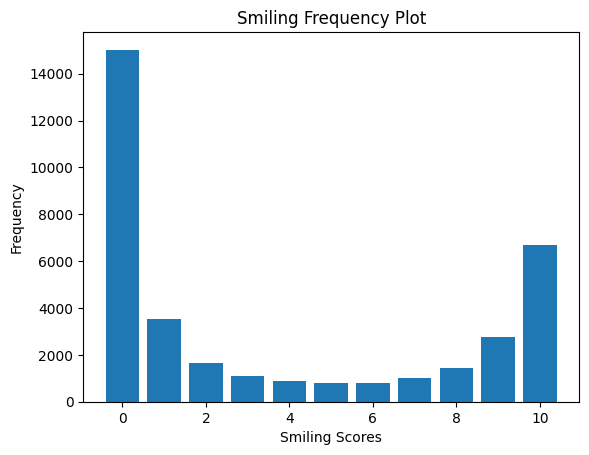

In [10]:
#drop irrelevant colums, find a good smiling score -> ((happiness + surprise) / ALL) * 10
df["smiling_score"] = df["happiness"] + df["surprise"]
freq = df["smiling_score"].value_counts()
plt.bar(freq.index, freq.values)

plt.xlabel('Smiling Scores')
plt.ylabel('Frequency')
plt.title('Smiling Frequency Plot')


Text(0.5, 1.0, 'Smiling Category Frequency Plot')

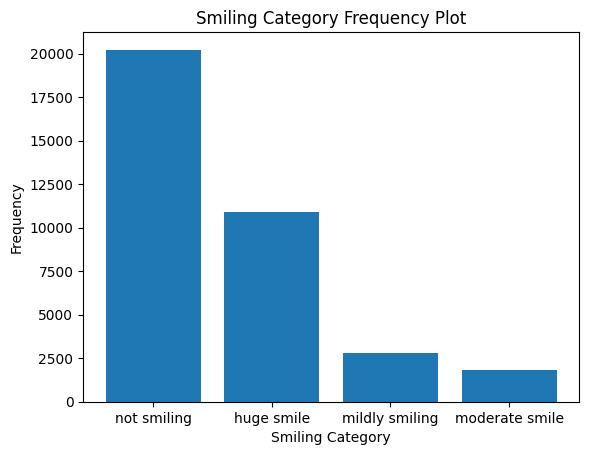

In [11]:
bin_edges = [-1, 2, 5, 7, 10]
bin_labels = ["not smiling", "mildly smiling", "moderate smile", "huge smile"]

# Create the binned Series
df["category"] = pd.cut(df["smiling_score"], bins=bin_edges, labels=bin_labels)

freq = df["category"].value_counts()
plt.bar(freq.index, freq.values)

plt.xlabel('Smiling Category')
plt.ylabel('Frequency')
plt.title('Smiling Category Frequency Plot')

In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df["category"])
df["category_enc"] = encoded_labels
df

,usage,img_name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF,smiling_score,category,category_enc
0,Training,..\..\data\FER2013Train\fer0000000.png,4,0,0,1,3,2,0,0,0,0,0,not smiling,3
1,Training,..\..\data\FER2013Train\fer0000001.png,6,0,1,1,0,0,0,0,2,0,1,not smiling,3
2,Training,..\..\data\FER2013Train\fer0000002.png,5,0,0,3,1,0,0,0,1,0,0,not smiling,3
3,Training,..\..\data\FER2013Train\fer0000003.png,4,0,0,4,1,0,0,0,1,0,0,not smiling,3
4,Training,..\..\data\FER2013Train\fer0000004.png,9,0,0,1,0,0,0,0,0,0,0,not smiling,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35881,PrivateTest,..\..\data\FER2013Test\fer0035796.png,5,0,0,3,0,0,0,0,2,0,0,not smiling,3
35882,PrivateTest,..\..\data\FER2013Test\fer0035797.png,8,0,0,2,0,0,0,0,0,0,0,not smiling,3
35884,PrivateTest,..\..\data\FER2013Test\fer0035799.png,0,0,0,0,7,1,0,2,0,0,0,not smiling,3
35885,PrivateTest,..\..\data\FER2013Test\fer0035800.png,0,10,0,0,0,0,0,0,0,0,10,huge smile,0


In [6]:
label_encoder.classes_ #index is the number

array(['huge smile', 'mildly smiling', 'moderate smile', 'not smiling'],
      dtype=object)

In [13]:
#remove useless columns, split dataset
df = df[["usage", "img_name", "category_enc"]]

df_train = df[df["usage"] == "Training"].reset_index(drop=True)
df_test = df[df["usage"] == "PrivateTest"].reset_index(drop=True)
df_valid = df[df["usage"] == "PublicTest"].reset_index(drop=True)

df_train

,usage,img_name,category_enc
0,Training,..\..\data\FER2013Train\fer0000000.png,3
1,Training,..\..\data\FER2013Train\fer0000001.png,3
2,Training,..\..\data\FER2013Train\fer0000002.png,3
3,Training,..\..\data\FER2013Train\fer0000003.png,3
4,Training,..\..\data\FER2013Train\fer0000004.png,3
...,...,...,...
28556,Training,..\..\data\FER2013Train\fer0028633.png,3
28557,Training,..\..\data\FER2013Train\fer0028634.png,3
28558,Training,..\..\data\FER2013Train\fer0028635.png,3
28559,Training,..\..\data\FER2013Train\fer0028636.png,3


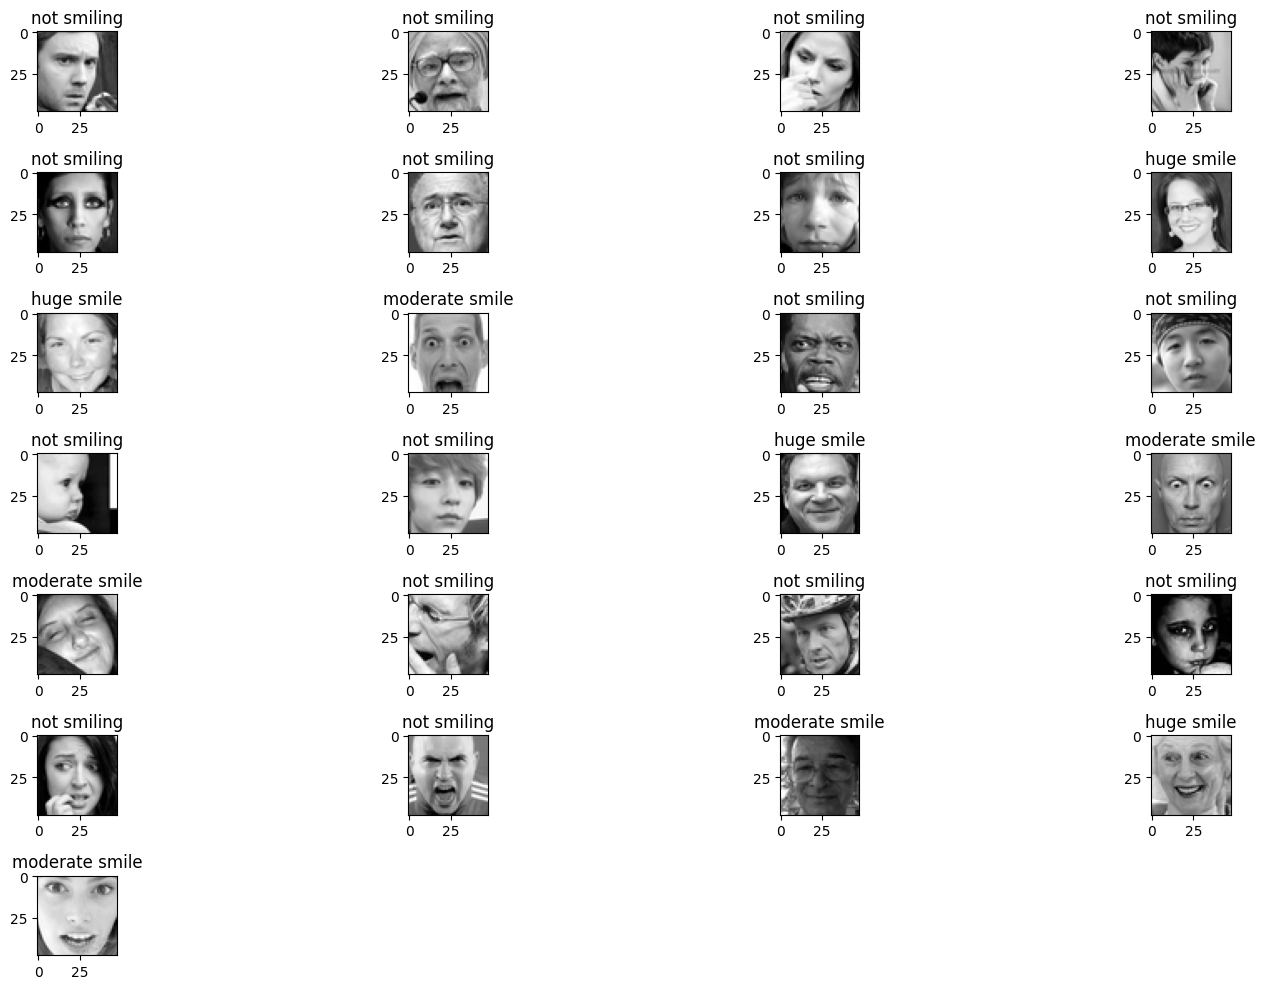

In [38]:
import matplotlib.image as mpimg
import os

# Define the directory where your images are stored
image_dir = 'path_to_directory'

# List all image files in the directory
image_files = df_train["img_name"][:25]

# Create a grid of subplots
num_images = len(image_files)
num_cols = 4  # Number of columns in the grid
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows needed

plt.figure(figsize=(15, 10))

for i, image_file in enumerate(image_files):
    plt.subplot(num_rows, num_cols, i + 1)
    
    # Load and display the image
    img = mpimg.imread(image_file)
    plt.imshow(img, cmap="gray")
    
    # Set subplot title as the image filename
    plt.title(label_encoder.inverse_transform([df_train["category_enc"][i]])[0])

# Adjust spacing between subplots
plt.tight_layout()

# Show the grid of images
plt.show()

In [16]:
class CustomRankingDataset(Dataset):
    err_count = 0
    def __init__(self, df):
        self.img_locs = df["img_name"]
        self.smiling_category = df["category_enc"]

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.img_locs)

    def __getitem__(self, idx):
        try:
            img_name = self.img_locs[idx]
            image = Image.open(img_name).convert('RGB')
            smiling_category = torch.tensor(self.smiling_category[idx], dtype=int)
            image = self.transform(image)

            return image, smiling_category

        except:
            CustomRankingDataset.err_count += 1
            print(f"Image loading exception occured: {CustomRankingDataset.err_count} {self.img_locs[idx]}")
            image = Image.open("..\\..\\data\\FER2013Train\\fer0000001.png").convert('RGB')
            smiling_score = torch.tensor(0 , dtype=int)
            image = self.transform(image)

            return image, smiling_score




# Create custom datasets and data loaders
train_dataset = CustomRankingDataset(df_train)
test_dataset = CustomRankingDataset(df_test)
val_dataset = CustomRankingDataset(df_valid)


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


print(f"train_len : {len(train_dataset)}, validation_len: {len(val_dataset)}, test_len: {len(test_dataset)}")

train_len : 28561, validation_len: 3579, test_len: 3574


### MODEL SPEC AND TRAINING

In [17]:
# Model arch: Effnet B0 + classifier network

model = efficientnet_b0(pretrained=True)
num_features = model._modules["classifier"][1].in_features
# print(num_features) # -> 1280

model._modules["classifier"][1] = nn.Sequential(
        nn.Linear(num_features, 64),
        nn.ReLU(),
        nn.Linear(64, 4),
        )


#loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
batches_per_epoch = (len(train_dataset) + len(val_dataset) ) // 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# torch.cuda.empty_cache()

model.to(device)


epochs_bar = tqdm.notebook.tqdm(range(num_epochs))
batches_bar = tqdm.notebook.tqdm(range(batches_per_epoch))


best_val_accuracy = 0.0
best_model_weights = model.state_dict()

for epoch in range(num_epochs):
    model.train()
    batches_bar.reset()

    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
      
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batches_bar.update()

    
    average_train_loss = running_loss / len(train_loader)
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate validation accuracy for the epoch
    val_accuracy = 100 * correct / total
    
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss: {average_train_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    
    # Check if the current model has the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = model.state_dict()
        torch.save(best_model_weights, '..\\smile_model.pth')

    epochs_bar.update()


C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1004 [00:00<?, ?it/s]

Epoch [1/20]
Train Loss: 0.5998
Validation Accuracy: 83.57%
Epoch [2/20]
Train Loss: 0.4680
Validation Accuracy: 84.27%
Epoch [3/20]
Train Loss: 0.4203
Validation Accuracy: 85.08%
Epoch [4/20]
Train Loss: 0.3788
Validation Accuracy: 85.11%
Epoch [5/20]
Train Loss: 0.3478
Validation Accuracy: 85.33%
Epoch [6/20]
Train Loss: 0.3162
Validation Accuracy: 85.33%
Epoch [7/20]
Train Loss: 0.2854
Validation Accuracy: 84.86%
Epoch [8/20]
Train Loss: 0.2594
Validation Accuracy: 83.51%
Epoch [9/20]
Train Loss: 0.2428
Validation Accuracy: 85.28%
Epoch [10/20]
Train Loss: 0.2158
Validation Accuracy: 83.63%
Epoch [11/20]
Train Loss: 0.1970
Validation Accuracy: 83.38%
Epoch [12/20]
Train Loss: 0.1743
Validation Accuracy: 84.58%


KeyboardInterrupt: 

In [26]:

model = efficientnet_b0(pretrained=False)
num_features = model._modules["classifier"][1].in_features

model._modules["classifier"][1] = nn.Sequential(
        nn.Linear(num_features, 64),
        nn.ReLU(),
        nn.Linear(64, 4),
        )

checkpoint = torch.load("..\\smile_model.pth")
model.load_state_dict(checkpoint)

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [27]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (abs(predicted - labels) <= 0.5).sum().item()

print(f"Test Accuracy: {100 * correct / total}%; correct : {correct} ; total: {total}")

# torch.save(model.state_dict(), 'model.pth')


cuda
Test Accuracy: 85.70229434806939%; correct : 3063 ; total: 3574
